# DS3-2 EDA "Median Prices of Existing Single Family Homes" dataset from the California Association of Realtors.

### Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [7]:
# Enforce copy-on-write behavior for pandas DataFrames
pd.options.mode.copy_on_write = True

# Folder Organization

In [8]:
# Read in the data file
# Load and clean DS3-2: Median Prices of Existing Single Family Homes

parent_dir = Path.cwd().parent
filepath = parent_dir / "data" / "ds3-2.csv"  # change path if your file is elsewhere
df = pd.read_csv(filepath)

# Convert Mon-Yr to datetime
df["date"] = pd.to_datetime(df["Mon-Yr"], format="%b-%y", errors="coerce")
df = df.sort_values("date")

# Identify value columns: all except Mon-Yr, date, and obvious junk
cols_to_skip = ["Mon-Yr", "date", "Unnamed: 55", "Cond"]
value_cols = [c for c in df.columns if c not in cols_to_skip]

# Clean currency strings: "$194,952" -> 194952.0
for col in value_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Set date as index for time-series work
df = df.set_index("date")

# check
df[value_cols].head()


,CA,Alameda,Amador,Butte,Calaveras,Contra-Costa,Del Norte,El Dorado,Fresno,Glenn,...,Yolo,Yuba,Condo,LA Metro,Central Coast,Central Valley,Far North,Inland Empire,S.F. Bay Area,SoCal
date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,194952,226149,NaN,102143,NaN,NaN,NaN,NaN,82083,NaN,...,NaN,NaN,141519,203390,NaN,NaN,NaN,NaN,227366,NaN
1990-02-01,196273,219306,NaN,83333,NaN,NaN,NaN,NaN,87187,NaN,...,NaN,NaN,144965,211024,NaN,NaN,NaN,NaN,234739,NaN
1990-03-01,194856,225162,NaN,100000,NaN,NaN,NaN,NaN,83889,NaN,...,NaN,NaN,141132,209286,NaN,NaN,NaN,NaN,235337,NaN
1990-04-01,196111,229333,NaN,108000,NaN,NaN,NaN,NaN,85428,NaN,...,NaN,NaN,145707,210302,NaN,NaN,NaN,NaN,233178,NaN
1990-05-01,195281,232291,NaN,100000,NaN,NaN,NaN,NaN,88749,NaN,...,NaN,NaN,146060,210148,NaN,NaN,NaN,NaN,235881,NaN


# Insight on why ds3
- ds3 covers more than 1 decade of data (from 1990 onward)
- its broken down by county/region, which lets us compare different parts of CA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429 entries, 1990-01-01 to 2025-09-01
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mon-Yr           429 non-null    object 
 1   CA               429 non-null    int64  
 2   Alameda          429 non-null    int64  
 3   Amador           259 non-null    float64
 4   Butte            429 non-null    int64  
 5   Calaveras        297 non-null    float64
 6   Contra-Costa     237 non-null    float64
 7   Del Norte        201 non-null    float64
 8   El Dorado        201 non-null    float64
 9   Fresno           429 non-null    int64  
 10  Glenn            237 non-null    float64
 11  Humboldt         429 non-null    int64  
 12  Imperial         81 non-null     float64
 13  Kern             429 non-null    int64  
 14  Kings            237 non-null    float64
 15  Lake             381 non-null    float64
 16  Lassen           117 non-null    float64
 1

In [10]:
df.shape

(429, 64)

# Columns with missing data. Probably will not use for analysis

In [40]:
missing = df.isna().sum().sort_values(ascending=False)
print(missing[(missing >=100)])


Unnamed: 55       429
Trinity           349
Imperial          348
Far North         312
Lassen            312
Plumas            284
Yolo              228
Del Norte         228
El Dorado         228
Central Valley    228
Madera            216
Tehama            213
Yuba              195
Sutter            195
Glenn             192
Contra-Costa      192
Kings             192
Mono              179
Amador            170
Tuolumne          156
Mariposa          156
Calaveras         132
Nevada            132
San Benito        108
dtype: int64


In [44]:
regions = ["CA", # Statewide
           "Los Angeles",
           "Orange",
           "Riverside",
           "San Bernardino",
           "San Diego",
           "Ventura",
           "Imperial",
           "Inland Empire", # aggregate region
           "SoCal", # aggregate region
           "LA Metro" # metro area
           ]

available_regions = [r for r in regions if r in df.columns]
print("Available regions in this file:", available_regions)

desc = df[available_regions].describe().T
desc

Available regions in this file: ['CA', 'Los Angeles', 'Orange', 'Riverside', 'San Bernardino', 'San Diego', 'Ventura', 'Imperial', 'Inland Empire', 'SoCal', 'LA Metro']


,count,mean,std,min,25%,50%,75%,max
CA,429.0,416540.585082,216233.647394,167790.0,209003.0,364040.0,554280.0,910160.0
Los Angeles,429.0,412404.773893,219367.446424,154313.0,212274.0,359477.0,550705.0,983230.0
Orange,429.0,599065.599068,340076.329413,192535.0,266550.0,561830.0,749697.0,1470000.0
Riverside,429.0,295585.037296,160777.217437,114367.0,143932.0,247092.0,405780.0,650000.0
San Bernardino,429.0,225083.608392,120180.704538,93664.0,131470.0,167035.0,301034.0,522700.0
San Diego,429.0,462093.510490,247485.136801,167083.0,215598.0,408483.0,607368.0,1054180.0
Ventura,429.0,493087.200466,229771.154482,192273.0,242310.0,461960.0,660000.0,985000.0
Imperial,81.0,330723.790123,52834.726149,237000.0,285950.0,335000.0,378160.0,457000.0
Inland Empire,333.0,308859.363363,144791.782922,105799.0,178238.0,291920.0,382277.0,611990.0
SoCal,369.0,421964.398374,218639.676289,79000.0,275000.0,410000.0,540000.0,888000.0


# Method to compute monthly returns (price changes) for housing in specific region

purpose: converts raw price levels into montly change rates which are stationary

In [45]:
# compute monthly price changes (returns)

def compute_returns(df: pd.DataFrame, region: str, method: str = "log") -> pd.Series:
    """
    Compute monthly price changes for a given region.

    method="log": log returns: log(P_t) - log(P_{t-1})
    method="pct": percent changes: (P_t - P_{t-1}) / P_{t-1}
    """
    if region not in df.columns:
        raise ValueError(f"Region '{region}' not found in columns")

    series = df[region].dropna()

    if method == "log":
        returns = np.log(series).diff()
    elif method == "pct":
        returns = series.pct_change()
    else:
        raise ValueError("method must be 'log' or 'pct'")

    return returns.dropna()



## func to compare actual returns vs normal distributions

In [47]:
# plot distribution of returns vs normal for a single region

def plot_returns_vs_normal(df: pd.DataFrame, region: str, method: str = "log"):
    """
    For the given region, compute monthly returns and:
      - print mean, std, skewness, and excess kurtosis
      - plot histogram with fitted normal PDF
      - plot Q-Q plot vs normal

    This is how we visually and statistically compare:
    "Are price changes normal or fat-tailed?"
    """
    returns = compute_returns(df, region, method=method)

    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()  

    print(f"=== {region} {method} returns ===")
    print(f"n = {len(returns)}")
    print(f"Mean: {mean:.6f}")
    print(f"Std: {std:.6f}")
    print(f"Skewness: {skew:.3f}")
    print(f"Excess Kurtosis: {kurt:.3f}\n")

    # Histogram with normal overlay
    plt.figure(figsize=(9,5))
    sns.histplot(returns, stat="density", bins=40)

    x = np.linspace(returns.min(), returns.max(), 300)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf)  # "normal" curve

    plt.title(f"{region} Monthly {method} Returns\nHistogram vs Normal PDF")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.show()

    # Q-Q plot against normal
    plt.figure(figsize=(6,6))
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f"{region} Monthly {method} Returns\nQ-Q Plot vs Normal")
    plt.show()


=== Los Angeles log returns ===
n = 428
Mean: 0.003548
Std: 0.056960
Skewness: -0.119
Excess Kurtosis: 0.117



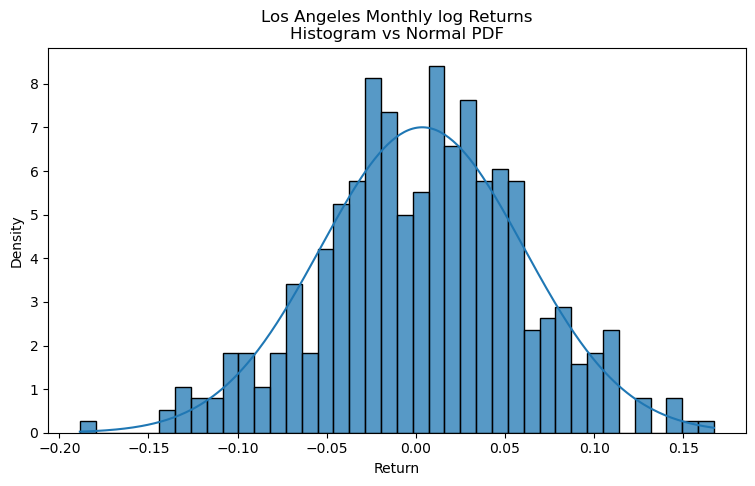

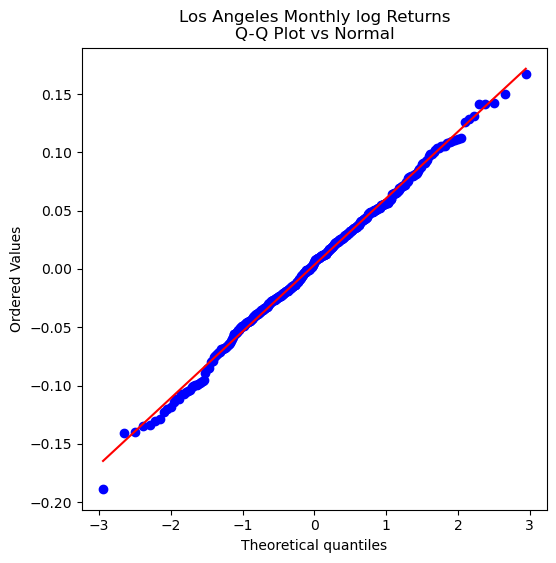

In [49]:
plot_returns_vs_normal(df, "Los Angeles", method="log")

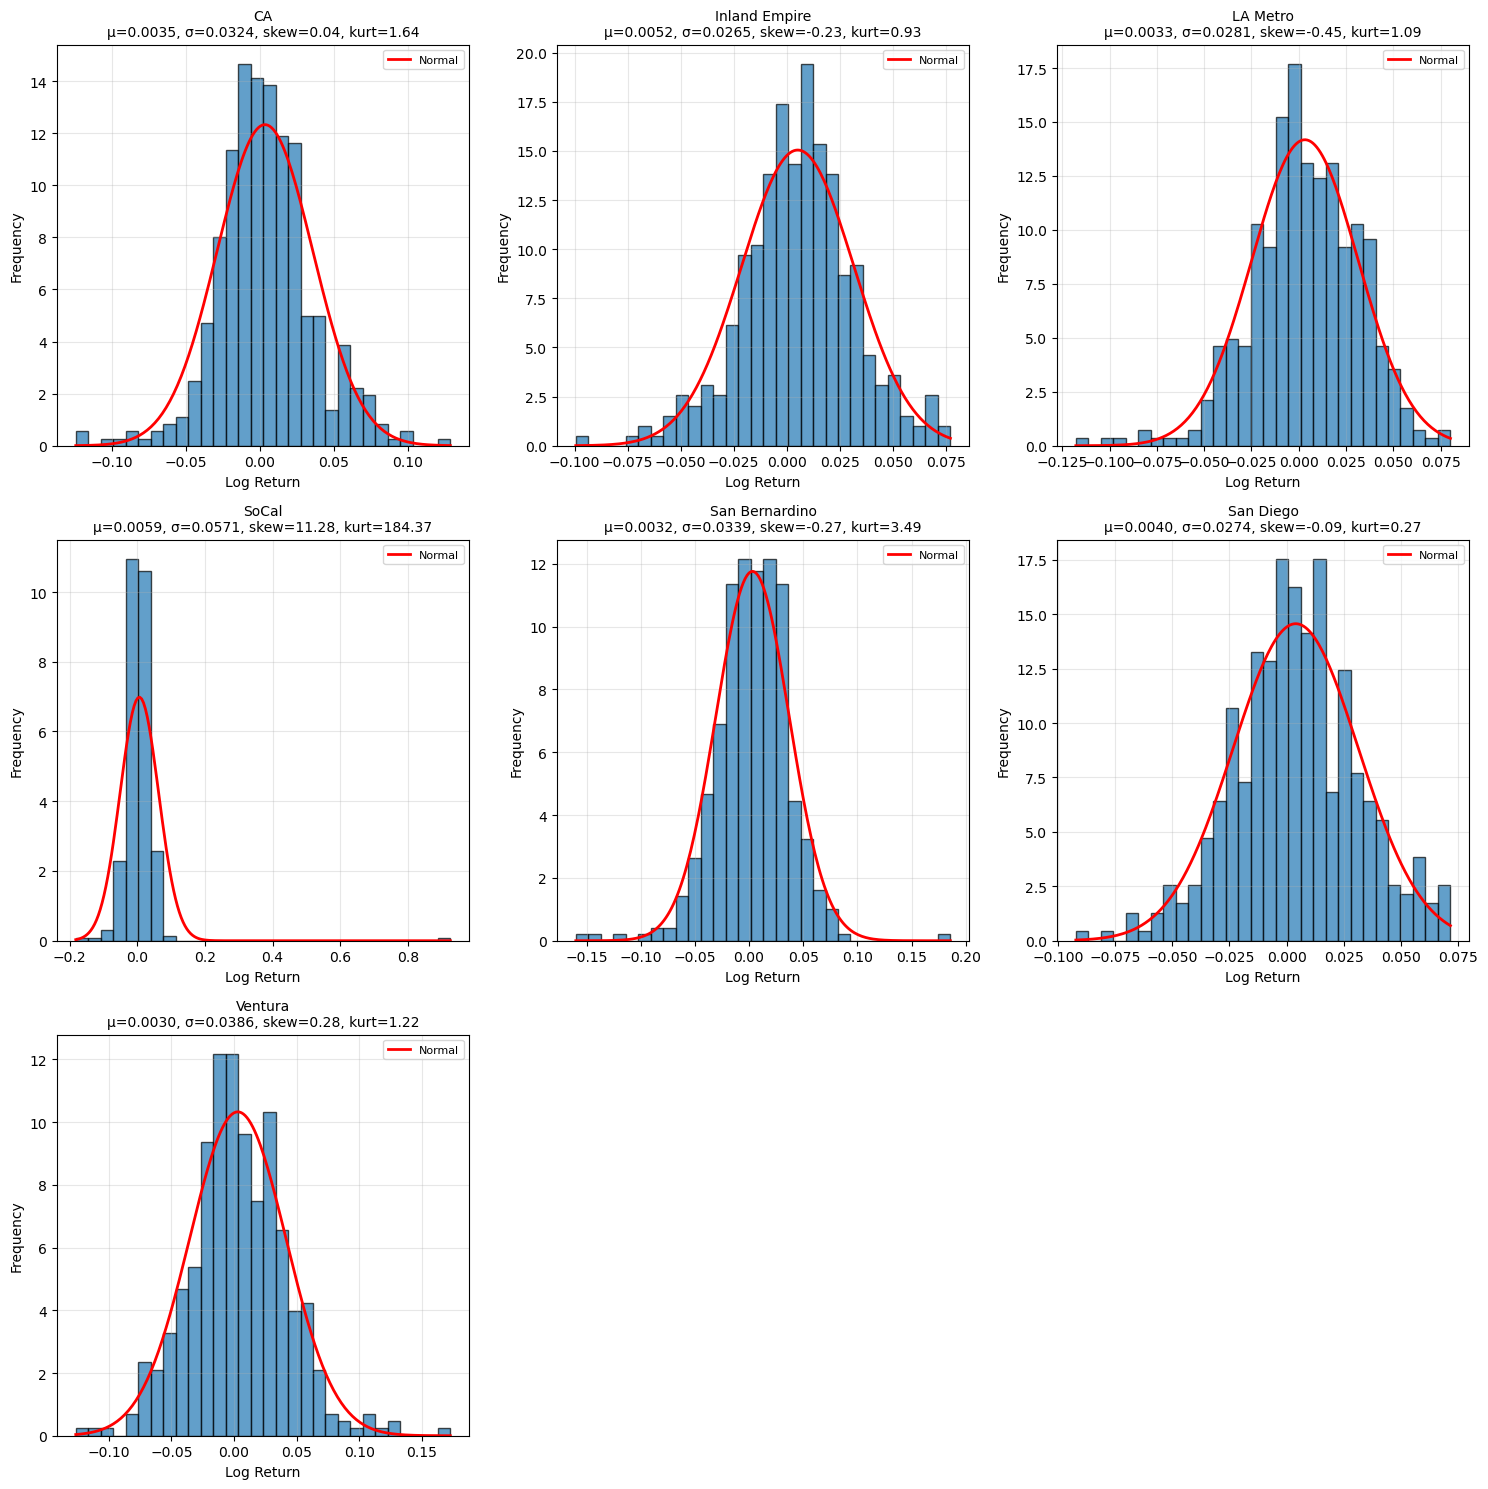

In [53]:
# Compare all SoCal regions side-by-side
regions = ["CA", "Inland Empire", "LA Metro", "SoCal", # "Los Angeles", "Oraange", "Riverside"
           "San Bernardino", "San Diego", "Ventura"] # Include "CA" "Inland Empire" "SoCal" "LA Metro" when needed

# Filter to available regions with sufficient data
available = [r for r in regions if r in df.columns and df[r].notna().sum() > 100]

# Create grid of subplots
n_regions = len(available)
n_cols = 3
n_rows = (n_regions + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, region in enumerate(available):
    returns = compute_returns(df, region, method="log")
    
    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()
    
    # Plot histogram with normal overlay
    ax = axes[i]
    ax.hist(returns, bins=30, density=True, alpha=0.7, edgecolor='black')
    
    x = np.linspace(returns.min(), returns.max(), 200)
    pdf = stats.norm.pdf(x, mean, std)
    ax.plot(x, pdf, 'r-', linewidth=2, label='Normal')
    
    ax.set_title(f"{region}\nμ={mean:.4f}, σ={std:.4f}, skew={skew:.2f}, kurt={kurt:.2f}", 
                 fontsize=10)
    ax.set_xlabel("Log Return")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for i in range(n_regions, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## All regions

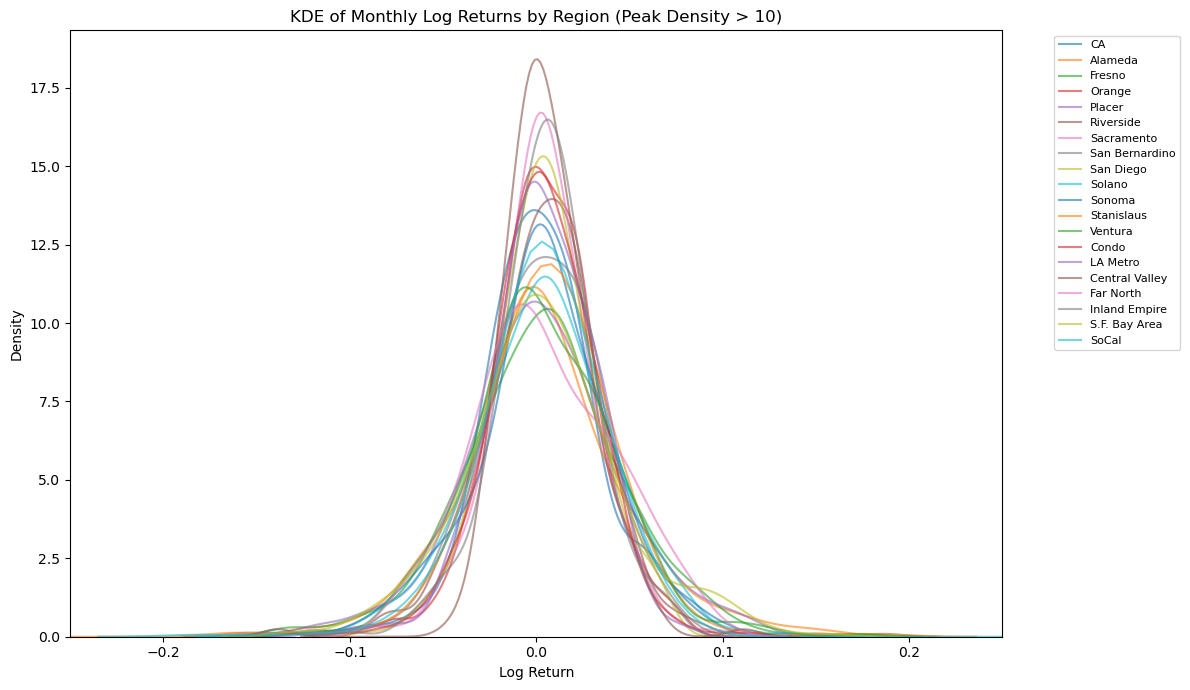

In [41]:
# KDE comparison across ALL regions (filtered by peak density > 10)

plt.figure(figsize=(12,7))

for col in value_cols:
    # Skip columns with insufficient data
    if df[col].notna().sum() < 50:
        continue
    ret = compute_returns(df, col, method="log")
    
    # Compute KDE to check peak density
    kde = stats.gaussian_kde(ret.dropna())
    x_eval = np.linspace(ret.min(), ret.max(), 200)
    density = kde(x_eval)
    
    # Only plot if max density > 10
    if density.max() > 10:
        sns.kdeplot(ret, label=col, alpha=0.6)

plt.title("KDE of Monthly Log Returns by Region (Peak Density > 10)")
plt.xlabel("Log Return")
plt.xlim(-0.25, 0.25)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Distribution plots + normal fit

=== CA log returns ===
n = 428
Mean: 0.003531
Std: 0.032359
Skewness: 0.036
Excess Kurtosis: 1.640


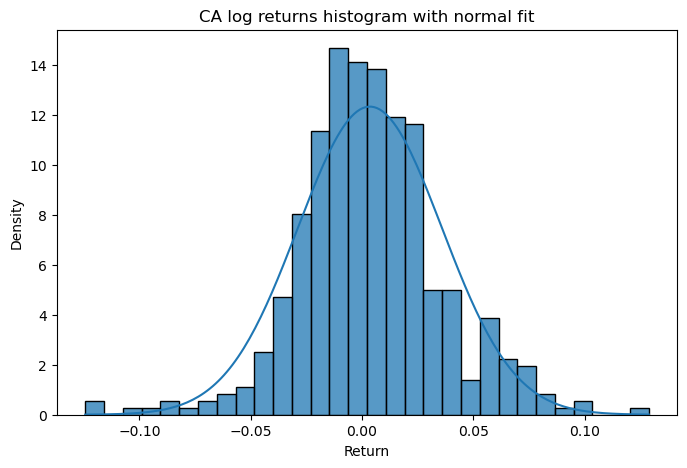

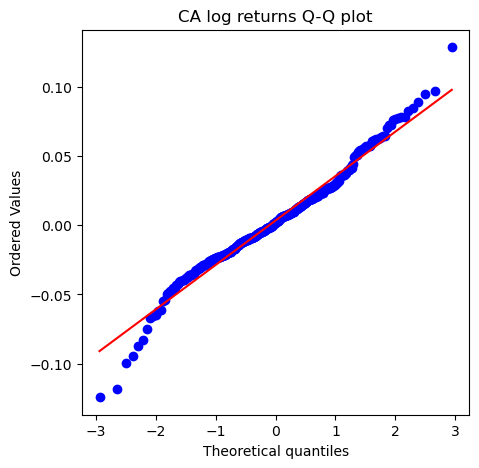

In [19]:
def analyze_distribution(df: pd.DataFrame, region: str, method: str = "log"):
    returns = compute_returns(df, region, method=method)

    mean = returns.mean()
    std = returns.std()
    skew = returns.skew()
    kurt = returns.kurtosis()  # excess kurtosis

    print(f"=== {region} {method} returns ===")
    print(f"n = {len(returns)}")
    print(f"Mean: {mean:.6f}")
    print(f"Std: {std:.6f}")
    print(f"Skewness: {skew:.3f}")
    print(f"Excess Kurtosis: {kurt:.3f}")

    # Histogram with normal pdf overlay
    plt.figure(figsize=(8, 5))
    sns.histplot(returns, stat="density", bins=30)
    x = np.linspace(returns.min(), returns.max(), 200)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf)
    plt.title(f"{region} {method} returns histogram with normal fit")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.show()

    # Q-Q plot vs normal
    plt.figure(figsize=(5, 5))
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title(f"{region} {method} returns Q-Q plot")
    plt.show()

# Example for statewide CA
analyze_distribution(df, "CA", method="log")


=== Los Angeles log returns ===
n = 428
Mean: 0.003548
Std: 0.056960
Skewness: -0.119
Excess Kurtosis: 0.117


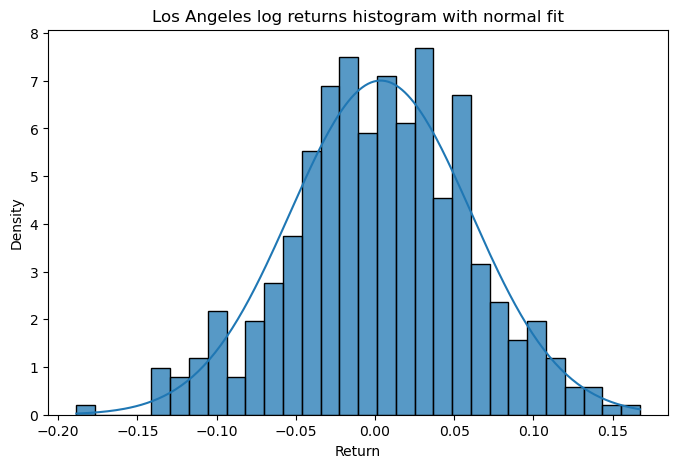

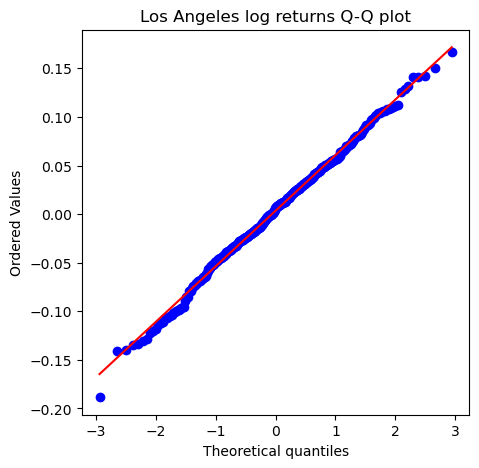

=== San Diego log returns ===
n = 428
Mean: 0.003977
Std: 0.027398
Skewness: -0.086
Excess Kurtosis: 0.272


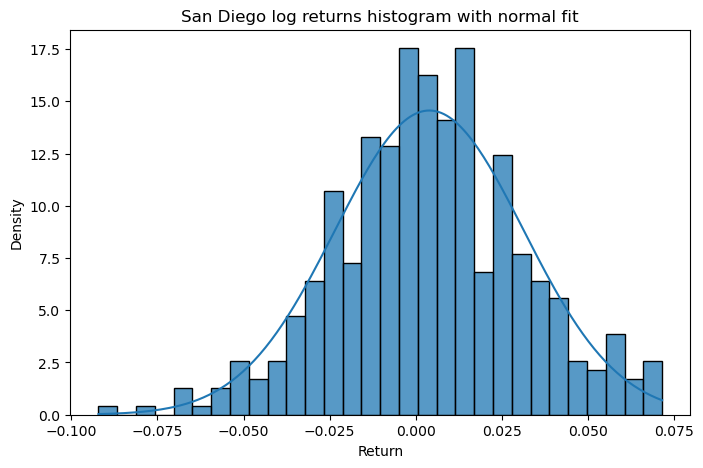

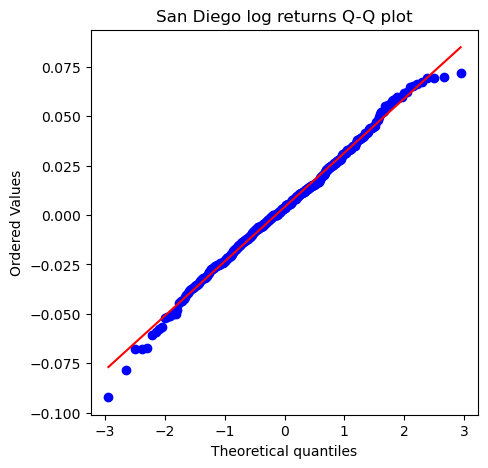

=== Orange log returns ===
n = 428
Mean: 0.004209
Std: 0.027632
Skewness: -0.239
Excess Kurtosis: 0.920


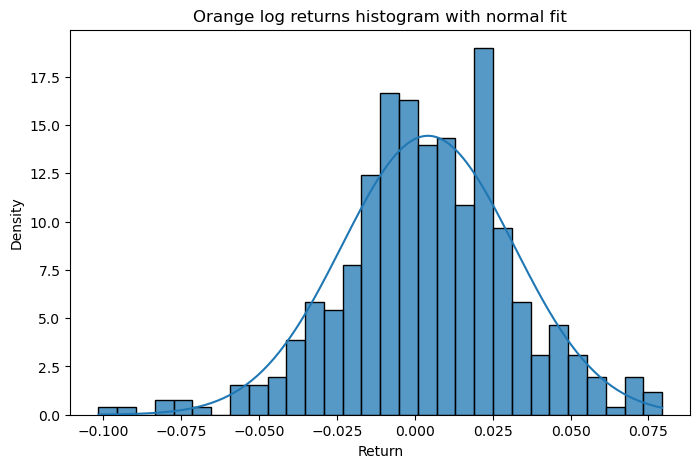

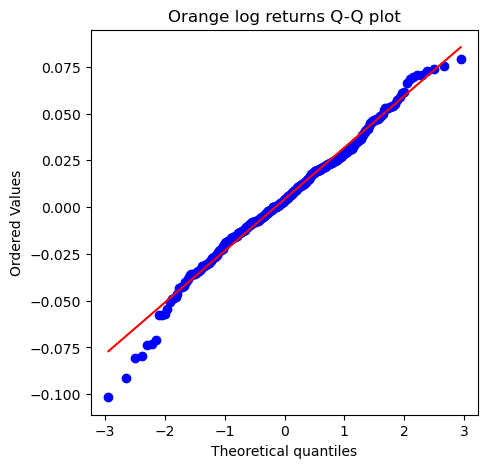

In [20]:
for r in ["Los Angeles", "San Diego", "Orange"]:
    if r in df.columns:
        analyze_distribution(df, r, method="log")
